In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.functional as F

import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
seed = 22

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
path = './'

In [4]:
image_label = pd.read_csv(path+'images.csv')
image_label

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [5]:
cols = ['Not sure', 'Body', 'Other', 'Skip']
image_label = image_label.loc[~image_label['label'].isin(cols)]

In [6]:
classes = image_label['label'].unique()
tmp = {}
for idx, c in enumerate(classes):
    tmp[c] = idx

image_label['label'] = image_label['label'].map(tmp)

C:\Users\swwho\AppData\Local\Temp\ipykernel_16740\679940750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_label['label'] = image_label['label'].map(tmp)


In [7]:
tmp

{'T-Shirt': 0,
 'Shoes': 1,
 'Shorts': 2,
 'Shirt': 3,
 'Pants': 4,
 'Skirt': 5,
 'Top': 6,
 'Outwear': 7,
 'Dress': 8,
 'Longsleeve': 9,
 'Undershirt': 10,
 'Hat': 11,
 'Polo': 12,
 'Blouse': 13,
 'Hoodie': 14,
 'Blazer': 15}

In [8]:
train, test = train_test_split(image_label, test_size = 0.2, random_state=123, stratify=image_label['label'])
train.to_csv(path+'train.csv', index=False)
test.to_csv(path+'test.csv', index=False)

<BarContainer object of 16 artists>

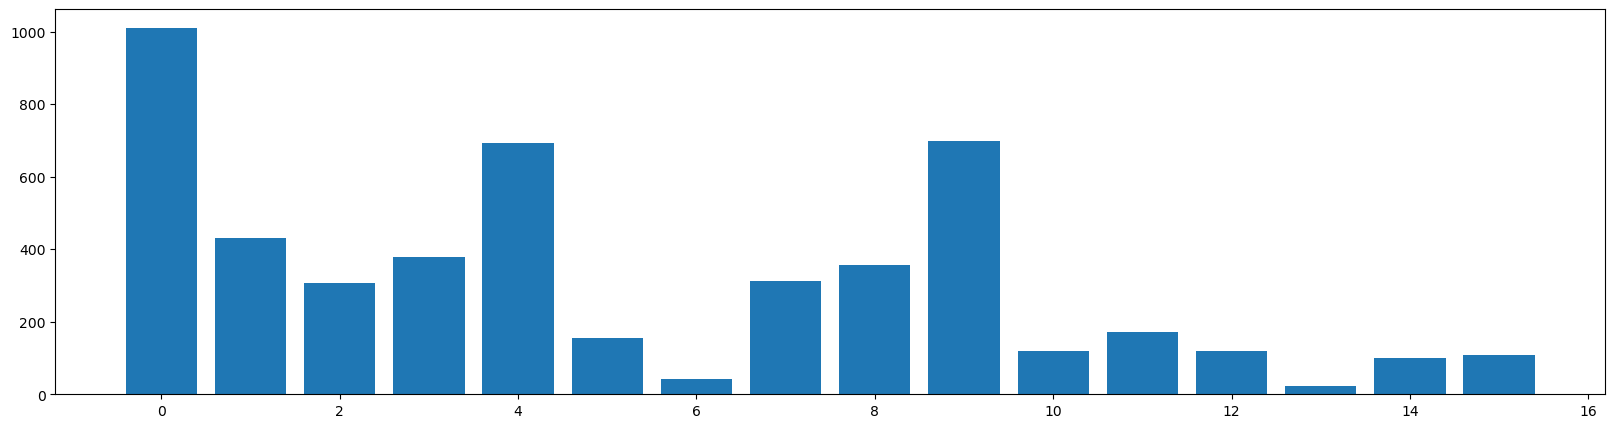

In [9]:
plt.figure(figsize=(20,5))
plt.bar(x=image_label['label'].value_counts().index, height=image_label['label'].value_counts())

In [10]:
class clothdataset():
    def __init__(self, path, csv_path, test=False, transform=None, target=None):
        self.path = path
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.target = target
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.path + 'images_compressed/' + self.data.iloc[idx]['image'] + '.jpg'
        img = Image.open(img_path)
        if self.target:
            if self.target and self.data.iloc[idx]['label'] in self.target:
                img = self.transform[1](img)
            else:
                img = self.transform[0](img)
        else:
            img = self.transform(img)
        if self.test:
            return img
        else:
            img_label = self.data.iloc[idx]['label']
            return img, img_label

In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [12]:
train_dataset = clothdataset(path, path+'train.csv', test=False, transform=[transform, target_transform], target=[1,2,3,5,6,7,8,10,11,12,13,14,15])
test_dataset = clothdataset(path, path+'test.csv', test=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class ClothClassification(nn.Module):
    def __init__(self):
        super(ClothClassification, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32*218*218, 16)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32*218*218)
        x = self.fc(x)
        return x

In [14]:
model = ClothClassification()

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        return focal_loss.mean()
    
focal_loss = FocalLoss(gamma=2, alpha=None)

In [16]:
# criterion = nn.CrossEntropyLoss()
criterion = focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ClothClassification(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1520768, out_features=16, bias=True)
)

In [17]:
num_epoch = 30

In [21]:
def train(train_dataloader):
    for epoch in range(num_epoch):
        model.train()
        print(f'Epoch {epoch}/{num_epoch}')
        result = []
        y_result = []
        running_loss = 0
        for x, y in tqdm(train_dataloader):
            y_result += y
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            _, tmp_result = torch.max(output, 1)
            result += tmp_result
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f1_score(result, y_result, average='macro'), running_loss/len(train_dataloader))
        
        model.eval()
        correct = 0
        total = 0
        result = []
        y_result = []

        with torch.no_grad():
            for x, y in tqdm(test_dataloader):
                y_result += y
                x, y = x.to(device), y.to(device)
                output = model(x)
                _, output = torch.max(output, 1)
                result += output
                # print(output)
        print(f'F1 Score: {f1_score(result,y_result, average="macro")}')

In [ ]:
train(train_dataloader)

Epoch 0/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [51:05<00:00, 24.33s/it]


0.27398298389509673 56.60943945627364


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:20<00:00,  2.50s/it]


F1 Score: 0.14614918992827386
Epoch 1/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [54:32<00:00, 25.97s/it]


0.3173048164901856 42.81524004255022


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:19<00:00,  2.48s/it]


F1 Score: 0.13966026657291924
Epoch 2/30


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [1:04:13<00:00, 30.58s/it]


0.36706843072708817 25.869140011923655


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.46s/it]


F1 Score: 0.17374392385298684
Epoch 3/30


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [1:14:43<00:00, 35.59s/it]


0.4060222881843978 15.700605460575648


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:19<00:00,  2.47s/it]


F1 Score: 0.1943820690593728
Epoch 4/30


100%|██████████████████████████████████████████████████████████████████████████████| 126/126 [1:11:41<00:00, 34.14s/it]


0.46500840372188795 8.980024593217033


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.46s/it]


F1 Score: 0.21270443289588023
Epoch 5/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [58:32<00:00, 27.87s/it]


0.5299355389532777 4.815406347077991


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.46s/it]


F1 Score: 0.23979085171489778
Epoch 6/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [34:18<00:00, 16.33s/it]


0.5658449606929487 2.7061328786233116


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.45s/it]


F1 Score: 0.22034825436242647
Epoch 7/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [21:47<00:00, 10.38s/it]


0.6024346086267947 1.5011192117891614


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:18<00:00,  2.45s/it]


F1 Score: 0.22776273732219465
Epoch 8/30


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [27:26<00:00, 13.07s/it]


0.6247552012611314 1.090124521936689


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:44<00:00,  5.13s/it]


F1 Score: 0.17984773375361152
Epoch 9/30


 82%|█████████████████████████████████████████████████████████████████▍              | 103/126 [26:16<05:52, 15.31s/it]

In [28]:
pd.read_csv('test.csv')

,image,sender_id,label,kids
0,fe21d6e5-b447-4ef4-ae4b-138cbf1a2220,116,0,False
1,85287925-224a-4f67-b34d-507b3859f962,48,12,False
2,6104b71c-017f-4631-95c9-6ff414091a7d,322,3,False
3,10e51a41-3729-472e-b288-f3b8f895577a,48,3,False
4,17e2ba0e-be9d-4fe4-b58b-2c039a693cb6,228,2,False
...,...,...,...,...
1001,df8283c4-33a7-4bc3-b2ef-2f9c62b15c18,262,8,False
1002,7e697e4d-ff1c-4478-85c6-a5715a1b3f31,48,0,False
1003,3bc940a9-c72f-4afb-ae60-6f65e01a507d,181,3,False
1004,cc0de3ab-d85a-45ff-93ea-d41520d09f1f,116,9,False


In [26]:
model.eval()
correct = 0
total = 0
result = []
y_result = []

with torch.no_grad():
    for x, y in tqdm(test_dataloader):
        y_result += y
        x, y = x.to(device), y.to(device)
        output = model(x)
        _, output = torch.max(output, 1)
        result += output
        print(output)
print(f'F1 Score: {f1_score(result,y_result, average="macro")}')

  3%|██▌                                                                                | 1/32 [00:05<02:45,  5.34s/it]

tensor([ 0,  0,  2,  0,  2,  4,  0,  7,  0,  3,  0,  2,  8,  7,  0,  0,  0,  9,
         9,  0,  0,  7, 11,  0,  0,  1,  4, 12, 11, 11,  8,  0])


  6%|█████▏                                                                             | 2/32 [00:12<03:11,  6.37s/it]

tensor([ 0,  0,  2,  3,  0,  0,  3,  0,  0,  8,  4,  0,  4,  4,  0,  8,  0,  4,
         0,  2,  0,  4, 11,  0,  0,  3, 15,  8,  0,  8,  0,  0])


  6%|█████▏                                                                             | 2/32 [00:16<04:09,  8.30s/it]


KeyboardInterrupt: 

In [36]:
test_image = pd.read_csv('test.csv')
test_image['label'].value_counts()

0     202
9     140
4     138
1      86
3      76
8      71
2      62
7      62
11     34
5      31
12     24
10     24
15     22
14     20
6       9
13      5
Name: label, dtype: int64

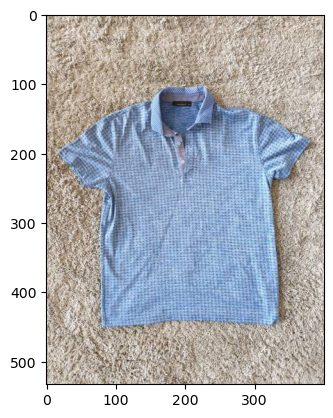

In [29]:
img = Image.open('images_compressed/85287925-224a-4f67-b34d-507b3859f962.jpg')
plt.imshow(img)

# img = transform(img)
# img.to(device)
# y = model(img)

In [53]:
y

tensor([[ -2.5469,  -5.3233, -13.7097, -16.8440, -13.0321,  -7.2933, -17.7931,
         -15.0667, -11.3365,  -7.2567,  -8.8498, -10.7855, -14.9168, -19.9426,
         -16.0471, -16.9808]], grad_fn=<AddmmBackward0>)

In [54]:
_, result = torch.max(y, 1)
result

tensor([0])